# Preprocessing Practice

Includes:

- tokenization
- converting tokens into token IDs
- adding special context tokens
- byte pair encoding
- data sampling with a sliding window
- creating token embeddings
- encoding word positions

## 1. Tokenization

In [1]:
import urllib.request
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

url = ("https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x10806b250>)

In [2]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print(f'Total length of characters in "The Verdict", a short story: {len(raw_text)}')
print(raw_text[:99])

Total length of characters in "The Verdict", a short story: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [3]:
import re

In [4]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item for item in preprocessed if item.strip()]
print(f'length of preprocessed text: {len(preprocessed)}')

length of preprocessed text: 4690


In [5]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


these are the tokens!

---

## 2. Converting tokens into token IDs

In [6]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(f'{vocab_size=}')

vocab_size=1130


In [7]:
vocab = {token: integer for integer, token in enumerate(all_words)}

In [8]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >=50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [9]:
## now, implemeting a simple text tokenizer

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        # (up) text preprocessed and converted to token strings
        # (down) token ids creation logic
        ids = [self.str_to_int[string] for string in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[id] for id in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [10]:
# now, instantiating a tokenizer object using this class and tokenize a pssage from the story.

tokenizer = SimpleTokenizerV1(vocab)

In [11]:
text = """"It's the last he painted, you know,"
        Mrs. Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
ids

[1,
 56,
 2,
 850,
 988,
 602,
 533,
 746,
 5,
 1126,
 596,
 5,
 1,
 67,
 7,
 38,
 851,
 1108,
 754,
 793,
 7]

In [12]:
decoded = tokenizer.decode(ids)
decoded

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [13]:
text = "Hello, do you like tea?"
# print(tokenizer.encode(text))

---

## 3. Adding special context tokens

Let's modify the vocabulary to add special tokens: `<unk>` and `<|endoftext|>`.

In [14]:
all_tokens = sorted(list(set(preprocessed))) # all words and special characters
print(len(all_tokens), type(all_tokens))

1130 <class 'list'>


In [15]:
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
print(len(all_tokens), type(all_tokens))

1132 <class 'list'>


In [16]:
# now constructing the vocab with these added tokens

vocab = {token:integer for integer, token in enumerate(all_tokens)}

#### Now updating my tokenizer class accordingly!

In [17]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.token_to_integer = vocab
        self.integer_to_token = {integer:token for token, integer in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [
            element for element in preprocessed if element.strip()
        ]
        
        # adding the update here:
        preprocessed = [element if element in self.token_to_integer
                        else "<|unk|>" for element in preprocessed]
        ids = [self.token_to_integer[token] for token in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.integer_to_token[integer] for integer in ids])
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text


In [18]:
# now trying this updated tokenizer (my own try):

tokenizerv2 = SimpleTokenizerV2(vocab)

text = """"It's the last he painted, you know,"
        And from here onwards, we talk about Nepal."""

ids = tokenizerv2.encode(text)
decoded_text = tokenizerv2.decode(ids)
decoded_text

'" It\' s the last he painted, you know," And from here <|unk|>, <|unk|> <|unk|> about <|unk|>.'

In [19]:
# trying this updated tokenizer with the book's example:

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
text

'Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.'

In [20]:
print(tokenizerv2.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [21]:
# now decoding the above encoded numbers

print(tokenizerv2.decode(tokenizerv2.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


---
## 4. Byte pair encoding

using tiktoken from here!

https://github.com/openai/tiktoken

In [22]:
from importlib.metadata import version
import tiktoken
print(f'tiktoken version: {version("tiktoken")}')

tiktoken version: 0.8.0


In [23]:
tik_tokenizer = tiktoken.encoding_for_model("gpt-2")

In [24]:
text = (
    "これはペンです。日本語で書いていますが、GPT-2さんはこれを理解出るのでしょうか？<|endoftext|>LFGGGGGGGGG<|endoftext|>"
    "ठिक छ, केही नेपाली शब्दहरू पनि? के GPT-2 यसलाई इन्कोड र डिकोड गर्न सक्छ?<|endoftext|>"
)

integers = tik_tokenizer.encode(text, allowed_special={"<|endoftext|>"})
integers

[46036,
 39258,
 31676,
 1209,
 248,
 6527,
 30640,
 33623,
 16764,
 33768,
 98,
 17312,
 105,
 45739,
 252,
 30640,
 162,
 249,
 116,
 18566,
 28134,
 18566,
 30159,
 33623,
 35585,
 23513,
 38,
 11571,
 12,
 17,
 43357,
 22174,
 31676,
 46036,
 39258,
 31758,
 49426,
 228,
 164,
 100,
 96,
 49035,
 118,
 25748,
 5641,
 30640,
 22180,
 1792,
 229,
 29557,
 27370,
 171,
 120,
 253,
 50256,
 43,
 37,
 40415,
 38,
 50256,
 11976,
 254,
 11976,
 123,
 11976,
 243,
 28225,
 249,
 11,
 28225,
 243,
 24231,
 229,
 11976,
 117,
 24231,
 222,
 28225,
 101,
 24231,
 229,
 11976,
 103,
 48077,
 11976,
 110,
 24231,
 222,
 28225,
 114,
 11976,
 105,
 24231,
 235,
 11976,
 99,
 11976,
 117,
 11976,
 108,
 24231,
 224,
 28225,
 103,
 11976,
 101,
 11976,
 123,
 30,
 28225,
 243,
 24231,
 229,
 402,
 11571,
 12,
 17,
 28225,
 107,
 11976,
 116,
 11976,
 110,
 48077,
 11976,
 230,
 28225,
 229,
 11976,
 101,
 24231,
 235,
 11976,
 243,
 24231,
 233,
 11976,
 94,
 28225,
 108,
 28225,
 94,
 11976,
 12

In [25]:
tokens = tik_tokenizer.decode(integers)
tokens

'これはペンです。日本語で書いていますが、GPT-2さんはこれを理解出るのでしょうか？<|endoftext|>LFGGGGGGGGG<|endoftext|>ठिक छ, केही नेपाली शब्दहरू पनि? के GPT-2 यसलाई इन्कोड र डिकोड गर्न सक्छ?<|endoftext|>'

---

## 5. Data sampling with a sliding window


implementing a data loader that fetches the input–target pairs in figure 2.12 from the training dataset using a sliding window approach

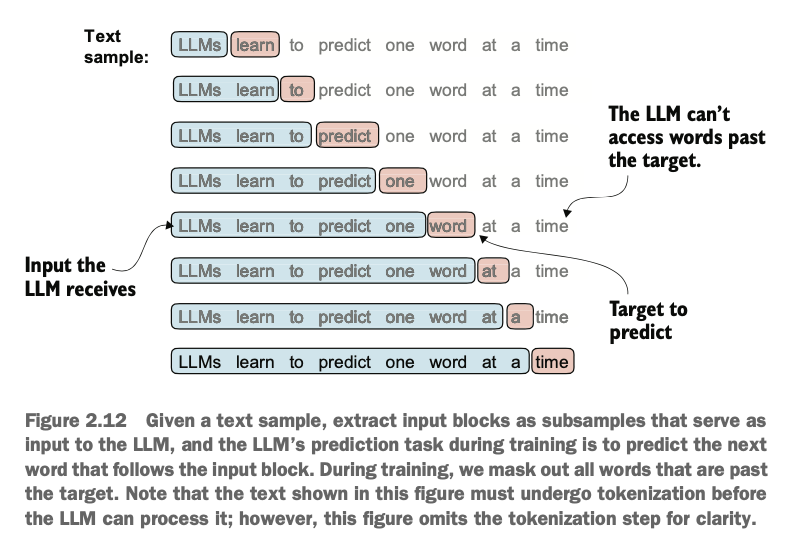

In [26]:
tik_tokenizer = tiktoken.encoding_for_model("gpt-2")
enc_text = tik_tokenizer.encode(raw_text)

In [27]:
#removing the first 50 tokens from the dataset for demonstration purposes

enc_sample = enc_text[50:]
context_size = 4
print(enc_sample[:10])

[290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686]


In [28]:
## creating te next word prediction task:

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(f'{context} ====> {desired}')
    print(f'Decoded text of these token IDs below:\n{tik_tokenizer.decode(context)} ====> {tik_tokenizer.decode([desired])}\n')

[290] ====> 4920
Decoded text of these token IDs below:
 and ====>  established

[290, 4920] ====> 2241
Decoded text of these token IDs below:
 and established ====>  himself

[290, 4920, 2241] ====> 287
Decoded text of these token IDs below:
 and established himself ====>  in

[290, 4920, 2241, 287] ====> 257
Decoded text of these token IDs below:
 and established himself in ====>  a



---

## 6. Efficient Data Loader Implementation with PyTorch

with its built-in `Dataset` and `DataLoader` classes

see Datasets & DataLoaders documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

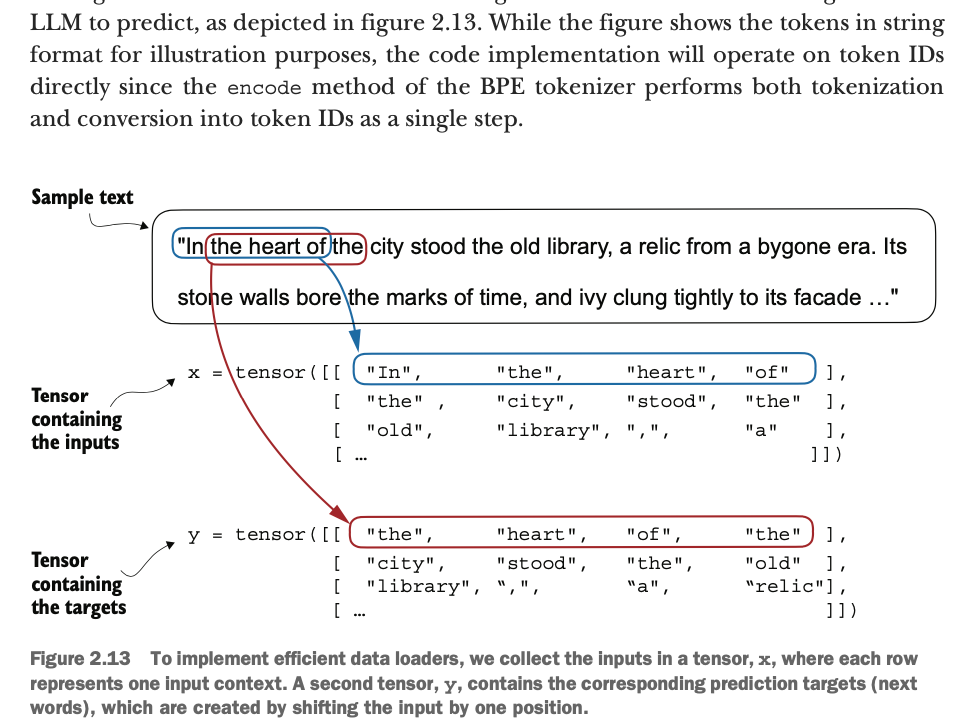

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

In [30]:
# print(len(raw_text))
# token_IDs = tik_tokenizer.encode(raw_text)
# print(len(token_IDs))

In [31]:
# a dataset interface for batched inputs and targets

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # tokenize the entire text
        token_ids = tokenizer.encode(txt)

        # using a sliding window to chunk the book into overlapping sequences of max_length
        for i in range (0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i+max_length]
            target_chunk = token_ids[i+1 : i+max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
        
    # __len__ function returns the total number of rows (or "samples") in the dataset
    def __len__(self):
        return len(self.input_ids)
    
    # __getitem__ function loads and returns a single row (a "sample") from the dataset at the given index `idx`
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [32]:
# now creating a dataloader function with this interface

def create_dataloader_v1(
        txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers
    )
    return dataloader

In [33]:
# testing it

dataloader = create_dataloader_v1(
    raw_text, batch_size=4, max_length=1, stride=1, shuffle=False)

# Converts dataloader into a Python iterator to fetch the next entry via Python’s built-in next() function
data_iter = iter(dataloader)

first_batch = next(data_iter)

print(first_batch)

[tensor([[  40],
        [ 367],
        [2885],
        [1464]]), tensor([[ 367],
        [2885],
        [1464],
        [1807]])]


In [34]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[1807],
        [3619],
        [ 402],
        [ 271]]), tensor([[ 3619],
        [  402],
        [  271],
        [10899]])]


#### Using the data loader to sample with a batch size greater than 1

In [35]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4, shuffle=False
)
# to the revision me: think about why I set stride 4 instead of just
# leaving it as 1 like before. this is deliberate and has to do with 
# preventing overlaps between batches. but see what effect it has on the targets.

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


---
## 7. Creating Token Embeddings
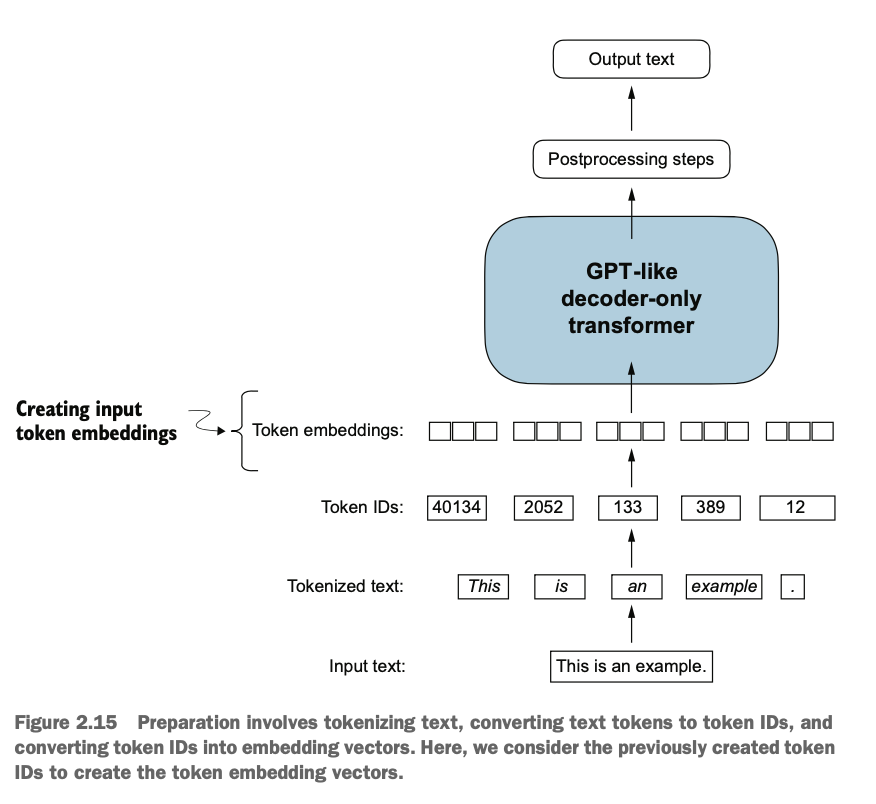

As a preliminary step, these embedding weights are initialized with random values. This initialization serves as the starting point for the LLM’s learning process. Then later, the embedding weights need to be optimized as part of the LLM training.

In [36]:
# suppose

input_ids = torch.tensor([2, 3, 5, 1])
vocab_size = 6
output_dim = 3

In [37]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
embedding_layer.weight

# remember that the generated embedding layer weights at this point have nothing to do with
# my input ids, this gets applied in the following cell

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)

In [38]:
print(embedding_layer(input_ids)) 
# this is the embedding vector I need.
# Each row in this output matrix is obtained via a lookup operation from the embedding weight matrix

# btw, this is just an outline with random values. not to be confused with raw_text; that comes after this demo.

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


This is basically what's happening:
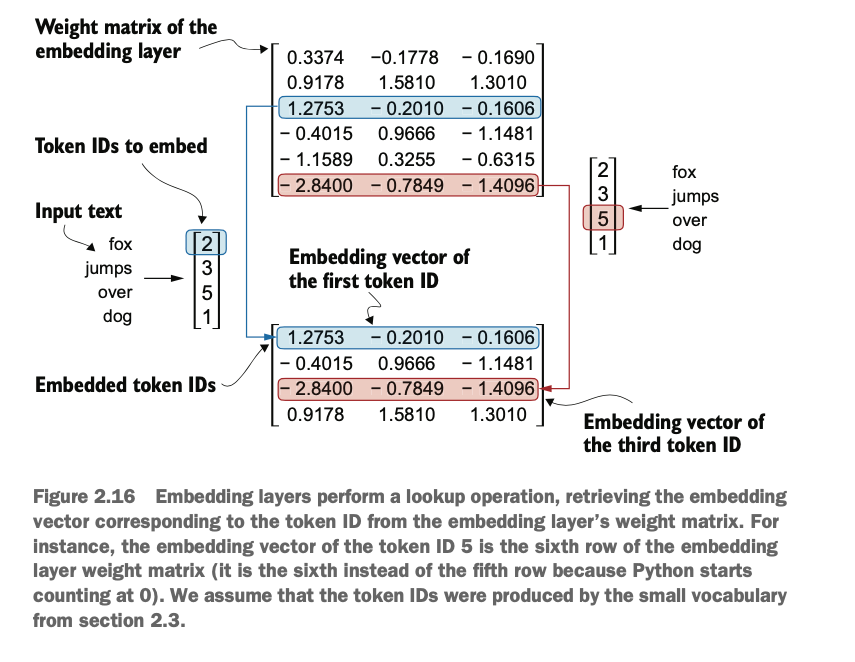

---
## 8. Encoding word positions

The token embedding I just did does not have any info regarding the positions or order of the tokens being embedded (it is deterministic, position-independent embedding of the token ID). The self-attention mechanism of the transformer, however, relies on both positions and order of tokens. So, word position encoding is further required here (if it is a transformer).
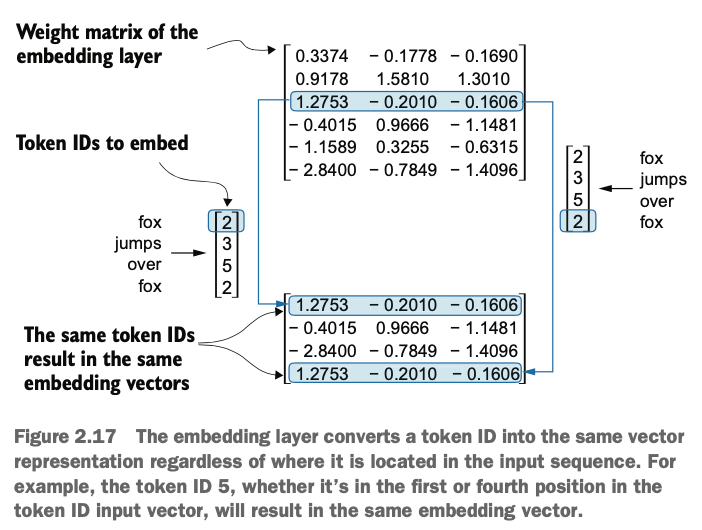

#### creating initial position embeddings

In [39]:
vocab_size = 50257 # of the bytepair encoding tokenizer
output_dim = 256 # 256-dimension vector representation
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [40]:
max_length = 4

dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

## just for reference to see the next data iteration
inputs2, targets2 = next(data_iter)
print("--------------------------------------------\nNext batch of Token IDs:\n", inputs2)
print("\nInputs shape:\n", inputs2.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])
--------------------------------------------
Next batch of Token IDs:
 tensor([[  287,   262,  6001,   286],
        [  465, 13476,    11,   339],
        [  550,  5710,   465, 12036],
        [   11,  6405,   257,  5527],
        [27075,    11,   290,  4920],
        [ 2241,   287,   257,  4489],
        [   64,   319,   262, 34686],
        [41976,    13,   357, 10915]])

Inputs shape:
 torch.Size([8, 4])


#### ↑ What is happening?

<!-- The token ID tensor is 8 × 4 dimensional, meaning that the data batch consists of eight text samples with four tokens each for each text sample. -->

We know that `batch_size=8`, which means each batch will contain 8 sequences (or samples) from the data, and each sequence is `max_length=4`, so we see 4 on each row (each row here is 1 sequence out of 8 sequences we set for each batch of texts).

The batch keeps on continuing until the whole `raw_text` is done. What I see being printed here as `Token IDs:` is just 1 part of my text.

In other words, `batch_size=8` doesn't mean the whole text is split into exactly 8 parts. It simply defines the number of sequences processed together in each batch. The loader will continue creating batches of size `[8, 4]` until the entire text has been processed.

===

In [41]:
token_embeddings = token_embedding_layer(inputs)
print(f'{token_embeddings.shape}\n\n{token_embeddings}')

torch.Size([8, 4, 256])

tensor([[[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
         [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
         [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
         [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],

        [[ 1.5460,  1.7368, -0.7848,  ..., -0.1004,  0.8584, -0.3421],
         [-1.8622, -0.1914, -0.3812,  ...,  1.1220, -0.3496,  0.6091],
         [ 1.9847, -0.6483, -0.1415,  ..., -0.3841, -0.9355,  1.4478],
         [ 0.9647,  1.2974, -1.6207,  ...,  1.1463,  1.5797,  0.3969]],

        [[-0.7713,  0.6572,  0.1663,  ..., -0.8044,  0.0542,  0.7426],
         [ 0.8046,  0.5047,  1.2922,  ...,  1.4648,  0.4097,  0.3205],
         [ 0.0795, -1.7636,  0.5750,  ...,  2.1823,  1.8231, -0.3635],
         [ 0.4267, -0.0647,  0.5686,  ..., -0.5209,  1.3065,  0.8473]],

        ...,

        [[-1.6156,  0.9610, -2.6437,  ..., -0.9645,  1.0888,  1.6383],
         [-0.3985, -0.9235, -1.3

#### ↑ What is happening?
The 8 × 4 × 256–dimensional tensor output shows that each token ID is now embedded as a 256-dimensional vector.

Btw, this `[8, 4, 256]` only refers to the first batch! Not for the whole raw_text. If we look at the first row of this output, we can see the following (next cell).

This means that each row in this sample represents one of the 4 tokens, and each number in a row (i.e., each column component) is a component of the 256-dimensional embedding vector for that token.

In [42]:
print(token_embeddings[0, :, :])

tensor([[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
        [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
        [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
        [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],
       grad_fn=<SliceBackward0>)


---

#### For a GPT model’s absolute embedding approach (since that's what GPT uses), we just need to create another embedding layer that has the same embedding dimension as the `token_embedding_layer`:

In [43]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings)
print(pos_embeddings.shape)

tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 256])


#### ↑ As I can see,
the positional embedding tensor consists of four 256-dimensional vectors. I can now add these **directly to the token embeddings**, where PyTorch will add the 4 × 256–dimensional `pos_embeddings` tensor to **each** 4 × 256–dimensional token embedding tensor in each of the eight sequences in each batch:

In [44]:
input_embeddings = token_embeddings + pos_embeddings
print(f'Input embeddings:\n{input_embeddings}\n\nShape: {input_embeddings.shape}')


# disclaimer: not to forget, this printed stuff I currently see is only for 1 single batch.
# There are lots of others batches as well.

# however, the positional embeddings are added to the token embeddings in every batch,
# not just a single batch that I can see right now ↓

Input embeddings:
tensor([[[ 2.2288,  0.5619,  0.8286,  ..., -0.6272, -0.2987,  0.8900],
         [ 2.0903, -0.4664, -0.0593,  ...,  0.9115, -1.0493, -1.6473],
         [-0.7158, -0.8304,  1.2494,  ...,  2.3952,  1.8773,  0.8051],
         [ 0.2703,  0.4029,  3.0514,  ...,  0.3595, -1.4548,  0.8310]],

        [[ 3.2835,  1.1749, -1.4150,  ..., -0.3281,  2.4332,  0.6924],
         [-0.2199, -0.9114, -0.1750,  ...,  1.5337, -0.1998,  0.1462],
         [ 1.5197, -1.4240,  0.4391,  ...,  1.0494, -1.4318,  2.3057],
         [ 0.2893,  0.8346, -0.1884,  ...,  1.9602,  0.8709,  0.8796]],

        [[ 0.9662,  0.0952, -0.4640,  ..., -1.0320,  1.6290,  1.7771],
         [ 2.4468, -0.2154,  1.4984,  ...,  1.8766,  0.5595, -0.1423],
         [-0.3856, -2.5393,  1.1556,  ...,  3.6157,  1.3267,  0.4944],
         [-0.2487, -0.5275,  2.0009,  ...,  0.2930,  0.5977,  1.3300]],

        ...,

        [[ 0.1219,  0.3991, -3.2740,  ..., -1.1921,  2.6637,  2.6728],
         [ 1.2438, -1.6436, -1.1101,  .

#### ↑ Importat Context:

The shape of one batch of `token_embeddings` is `[8, 4, 256]` but the shape of `pos_embeddings` is  `[4, 256]`. How does PyTorch add these tensors of different dimensions?

--> With broadcasting.\
https://pytorch.org/docs/stable/notes/broadcasting.html

I also wrote some detailed broadcasting examples [here](https://sumit.ml/resources/PyTorch-References).

#### Finally, one last reminder to myself again:
PyTorch is indeed handling embeddings for all the batches across the full length of `raw_text` here, even though I'm only seeing one batch printed out with shape `[8, 4, 256]`.

---

## Looking Back

In a high level, this is what I did in this notebook:

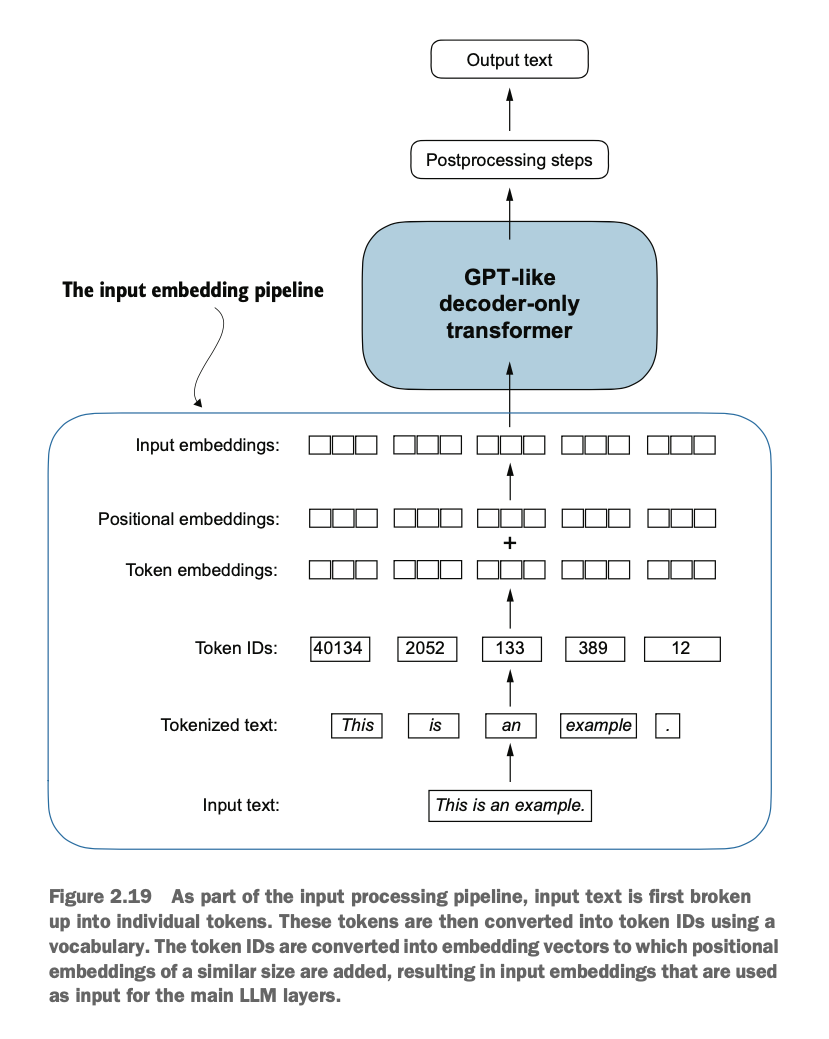

fin.